# Read Respose

Definitions And Constant

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from src.utils.imgutils import *
import src.constants as constants
from src.config import CONFIG_DEFAULTS as config
from src.logger import logger
import src.template2  as t
from src.processors.manager import ProcessorManager
PROCESSOR_MANAGER = ProcessorManager()
def normalize_util(img, alpha=0, beta=255):
    return cv2.normalize(img, alpha, beta, norm_type=cv2.NORM_MINMAX)

[08:50:22] INFO     Looking for processors in "src.processors"                                         ]8;id=467253;file:///home/jovyan/src/logger.py\logger.py]8;;\:]8;id=490814;file:///home/jovyan/src/logger.py#50\50]8;;\

           INFO     Loaded processors: ['CropOnMarkers', 'CropPage', 'FeatureBasedAlignment',          ]8;id=118611;file:///home/jovyan/src/logger.py\logger.py]8;;\:]8;id=300136;file:///home/jovyan/src/logger.py#50\50]8;;\
                    'GaussianBlur', 'Levels']                                                                      

Function Read Respose input Template.py  and image after preprocoessimg <br />
1- Resize image to Dimension in Template <br />
2-calculates Mean of pixals in esch squer in box
3-calculate standar devition to vals of mean squar 

In [2]:
def read_response(template,image, name, save_dir=None):
            img = image.copy()
           
            img = ImageUtils.resize_util(
                img, template.dimensions[0], template.dimensions[1]
            )
            if img.max() > img.min():
                img = normalize_util(img)
            
            transp_layer = img.copy()
            final_marked = img.copy()
            morph = img.copy()
            ImageUtils.append_save_img(3, morph)
            alpha = 0.65
            box_w, box_h = template.bubble_dimensions
            omr_response = {}
            multi_marked, multi_roll = 0, 0
            if config.outputs.show_image_level >= 5:
                all_c_box_vals = {"int": [], "mcq": []}
                # ,"QTYPE_ROLL":[]}#,"QTYPE_MED":[]}
                q_nums = {"int": [], "mcq": []}
                
            final_align = None
            if config.outputs.show_image_level >= 2:
                initial_align = ImageUtils.draw_template_layout(img, template, shifted=False)
                final_align = ImageUtils.draw_template_layout(
                    img, template, shifted=True, draw_qvals=True
                )
            all_q_vals, all_q_strip_arrs, all_q_std_vals = [], [], []
            total_q_strip_no = 0
            for q_block in template.q_blocks:
                q_std_vals = []
                for _, qbox_pts in q_block.traverse_pts:
                    q_strip_vals = []
                    for pt in qbox_pts:
                        # shifted
                        x, y = (pt.x + q_block.shift, pt.y)
                        rect = [y, y + box_h, x, x + box_w]
                        vv = cv2.mean(img[rect[0] : rect[1], rect[2] : rect[3]])[0]
                        display("The mean of all pixal in squar{} in box {}".format(pt,q_block))
                        q_strip_vals.append(
                            vv
                        )
                    ss = round(np.std(q_strip_vals), 2)
                    q_std_vals.append(ss, 2)
                    display("The standar Devition each Col = {} in block {}".format(ss ,q_block ))
                    all_q_strip_arrs.append(q_strip_vals)
                    all_q_vals.extend(q_strip_vals)
                    total_q_strip_no += 1
                all_q_std_vals.extend(q_std_vals)
            global_std_thresh, _, _ = get_global_threshold(
                all_q_std_vals
            ) 
            global_thr, _, _ = get_global_threshold(all_q_vals, looseness=4)
            # TODO colorama
            logger.info(
                "Thresholding:\t\t global_thr: ",
                round(global_thr, 2),
                "\tglobal_std_THR that used codution no_outliers: ",
                round(global_std_thresh, 2),
                "\t(Looks like a Xeroxed OMR)" if (global_thr == 255) else "",
            )
    
            per_omr_threshold_avg, total_q_strip_no, total_q_box_no = 0, 0, 0
            non_empty_qnos = set()
            for q_block in template.q_blocks:
                block_q_strip_no = 1
                shift = q_block.shift
                s, d = q_block.orig, q_block.dimensions
                key = q_block.key[:3]
                for _, qbox_pts in q_block.traverse_pts:
                    # All Black or All White case
                    no_outliers = all_q_std_vals[total_q_strip_no] < global_std_thresh
                    per_q_strip_threshold = get_local_threshold(
                        all_q_strip_arrs[total_q_strip_no],
                        global_thr,
                        no_outliers,
                        "Mean Intensity Histogram for "
                        + key
                        + "."
                        + qbox_pts[0].q_no
                        + "."
                        + str(block_q_strip_no),
                        config.outputs.show_image_level >= 6,
                    )
                    per_omr_threshold_avg += per_q_strip_threshold
                    display("per_omr_threshold_avg = {}".formst(per_omr_threshold_avg))
                    for pt in qbox_pts:
                        # shifted
                        x, y = (pt.x + q_block.shift, pt.y)
                        boxval0 = all_q_vals[total_q_box_no]
                        detected = per_q_strip_threshold > boxval0
                        display("check if block dark or no :{}".format(detected))
                        if detected:
                            cv2.rectangle(
                                final_marked,
                                (int(x + box_w / 12), int(y + box_h / 12)),
                                (
                                    int(x + box_w - box_w / 12),
                                    int(y + box_h - box_h / 12),
                                ),
                                constants.CLR_DARK_GRAY,
                                3,
                            )
                        else:
                            cv2.rectangle(
                                final_marked,
                                (int(x + box_w / 10), int(y + box_h / 10)),
                                (
                                    int(x + box_w - box_w / 10),
                                    int(y + box_h - box_h / 10),
                                ),
                                constants.CLR_GRAY,
                                -1,
                            )

                        if detected:
                            q, val = pt.q_no, str(pt.val)
                            cv2.putText(
                                final_marked,
                                val,
                                (x, y),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                constants.TEXT_SIZE,
                                (20, 20, 10),
                                int(1 + 3.5 * constants.TEXT_SIZE),
                            )
                            multi_marked_l = q in omr_response
                            multi_marked = multi_marked_l or multi_marked
                            omr_response[q] = (
                                (omr_response[q] + val) if multi_marked_l else val
                            )
                            non_empty_qnos.add(q)
                            multi_roll = multi_marked_l and "Roll" in str(q)
                        total_q_box_no += 1      
                    if config.outputs.show_image_level >= 5:
                        if key in all_c_box_vals:
                            q_nums[key].append(key[:2] + "_c" + str(block_q_strip_no))
                            all_c_box_vals[key].append(
                                all_q_strip_arrs[total_q_strip_no]
                            )

                    block_q_strip_no += 1
                    total_q_strip_no += 1
            for concatQ in template.concatenations:
                for q in concatQ:
                    if q not in non_empty_qnos:
                        omr_response[q] = q_block.empty_val
            for q in template.singles:
                if q not in non_empty_qnos:
                    omr_response[q] = q_block.empty_val
            per_omr_threshold_avg /= total_q_strip_no
            per_omr_threshold_avg = round(per_omr_threshold_avg, 2)
            cv2.addWeighted(
                final_marked, alpha, transp_layer, 1 - alpha, 0, final_marked
            )
            if config.outputs.show_image_level >= 5:
                # plt.draw()
                f, axes = plt.subplots(len(all_c_box_vals), sharey=True)
                f.canvas.manager.set_window_title(name)
                ctr = 0
                type_name = {
                    "int": "Integer",
                    "mcq": "MCQ",
                    "med": "MED",
                    "rol": "Roll",
                }
                for k, boxvals in all_c_box_vals.items():
                    axes[ctr].title.set_text(type_name[k] + " Type")
                    axes[ctr].boxplot(boxvals)
                    axes[ctr].set_ylabel("Intensity")
                    axes[ctr].set_xticklabels(q_nums[k])
                    ctr += 1
                plt.tight_layout(pad=0.5)
                plt.show()
            return omr_response, final_marked, multi_marked, multi_roll


# Input

In [3]:
name = "sheet1.jpg" # name of image
image = cv2.imread("result_image.jpg")
# ⛔️ AttributeError: module 'json' has no attribute 'loads'
template = t.Template
template.__init__(template,"samples/sample1/template.json",PROCESSOR_MANAGER.processors)
omr_response, final_marked, multi_marked, multi_roll=read_response(template,image, name, save_dir=None)

[08:50:28] INFO     Validating template.json ...                                                         ]8;id=748930;file:///home/jovyan/src/utils/file.py\file.py]8;;\:]8;id=679211;file:///home/jovyan/src/utils/file.py#25\25]8;;\

           INFO     Template JSON validated successfully...                                            ]8;id=833744;file:///home/jovyan/src/logger.py\logger.py]8;;\:]8;id=253691;file:///home/jovyan/src/logger.py#50\50]8;;\

           INFO     Thresholding:            global_thr:  168.95    global_std_THR:  200               ]8;id=202235;file:///home/jovyan/src/logger.py\logger.py]8;;\:]8;id=884847;file:///home/jovyan/src/logger.py#50\50]8;;\

# Output

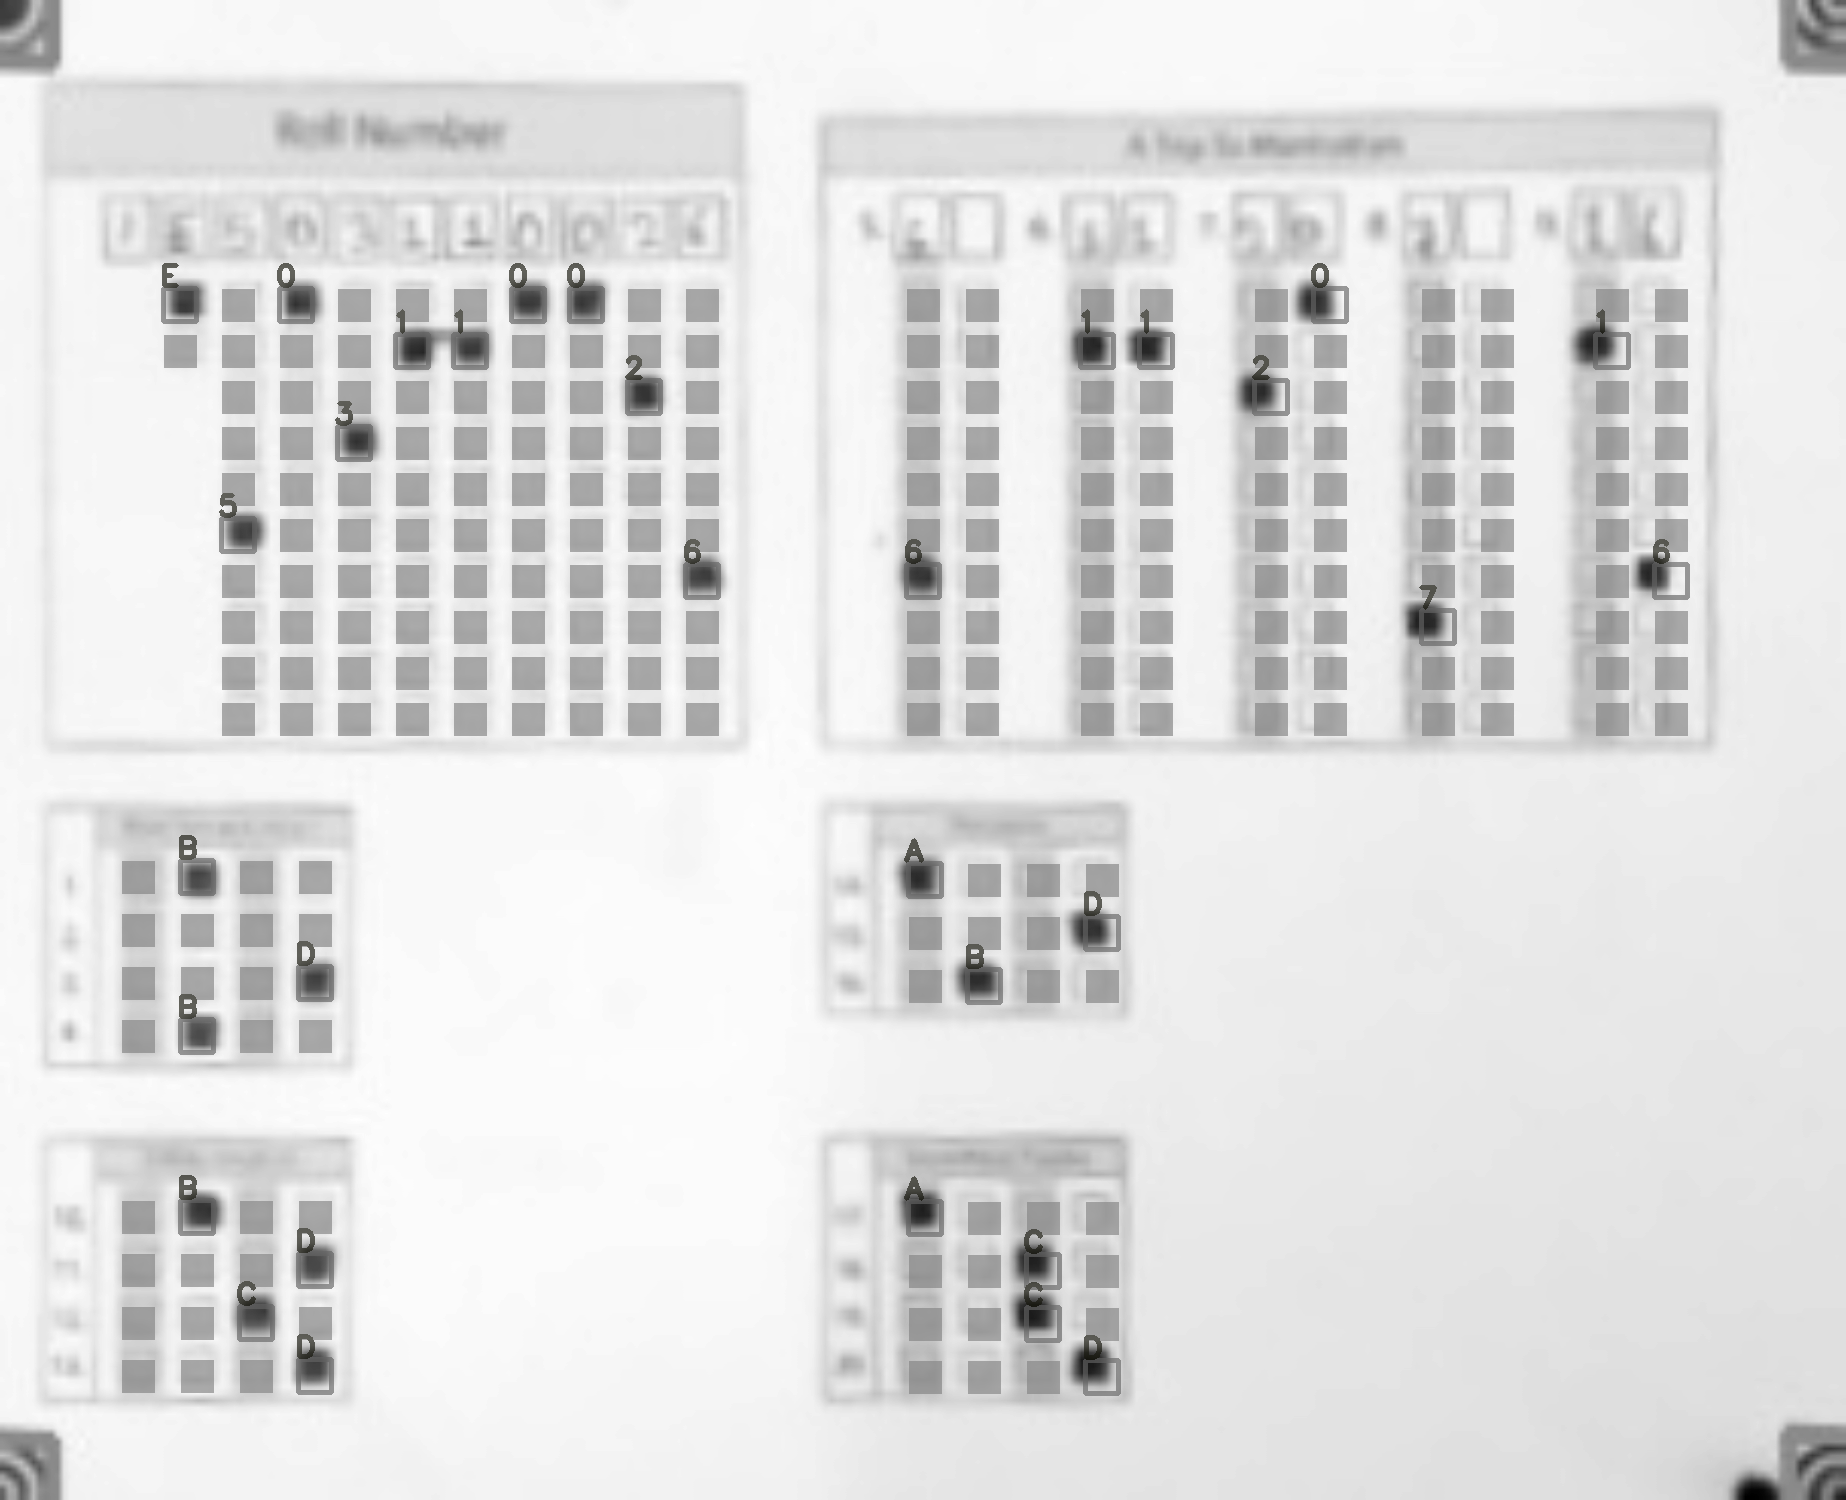

In [4]:
from IPython.display import display
from PIL import Image
display(Image.fromarray(final_marked))